In [1]:
import sys
sys.path.append("/opt/Banksy_py")
import banksy as banksy
import time; import random

from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
from banksy_utils.color_lists import spagcn_color
from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions
from banksy_utils.load_data import load_adata, display_adata
from banksy_utils.filter_utils import filter_cells
from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

/opt/Banksy_py/banksy/cluster_methods.py:18: UserWarning: 
No rpy2 installed. BANKSY will run, but mclust will not work.
Note: you can still use the default leiden option for clustering.
Install rpy2 and R in your conda environment if you want to use mclust for clustering.

  warnings.warn(warn_str)
2025-07-12 15:35:53.464943: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 15:35:53.476470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 15:35:53.489063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already 

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

# Load the data
sample_id = "IMMUNEX012"

adata = sc.read(f"/scratch/Projects/IMMUNEX/segmentation/bin2cell/bin2cell_output_he0.01_gex0.05/{sample_id}/adata_processed.h5ad")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata

AnnData object with n_obs × n_vars = 10130743 × 18190
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he', 'labels_he_expanded', 'labels_gex', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial', 'sample_id'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [3]:
# Load the metadata
metadata = pd.read_csv("~/rawdata/IMMUNEX/data/VisiumHD_18_2024_NSCLC.csv")

metadata_sample = metadata[metadata['Sample_code'] == sample_id]
adata.uns["sample_metadata"] = metadata_sample.iloc[0].to_dict()

display(adata.obs.head()) # Display the first few rows of the observation data (cell metadata)

,in_tissue,array_row,array_col,n_counts,destripe_factor,n_counts_adjusted,labels_he,labels_he_expanded,labels_gex,labels_joint,labels_joint_source
s_002um_00658_01498-1,1,658,1498,7.0,0.511111,11.244444,95209,95209,6062,95209,primary
s_002um_02587_02503-1,1,2587,2503,7.0,0.408824,8.994126,323573,323573,0,323573,primary
s_002um_01674_00710-1,1,1674,710,3.0,0.345482,7.600596,271331,271331,0,271331,primary
s_002um_02498_02808-1,1,2498,2808,3.0,0.192857,4.242857,308582,308582,24535,308582,primary
s_002um_00952_00136-1,1,952,136,1.0,0.056857,1.250864,0,123342,0,123342,primary


In [4]:
# Sampling adata 
# Set seed for reproducibility
np.random.seed(42)

# Compute number of cells to sample
n_obs = adata.n_obs
n_sample = int(n_obs * 0.01)
n_sample = int(n_obs * 1)

# Randomly choose indices
sample_indices = np.random.choice(n_obs, size=n_sample, replace=False)

# Subset the AnnData object
adata_sampled = adata[sample_indices].copy()

# Inspect new shape
print(adata_sampled)


AnnData object with n_obs × n_vars = 10130743 × 18190
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'destripe_factor', 'n_counts_adjusted', 'labels_he', 'labels_he_expanded', 'labels_gex', 'labels_joint', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'bin2cell', 'spatial', 'sample_id', 'sample_metadata'
    obsm: 'spatial', 'spatial_cropped_150_buffer'


In [5]:
adata_sampled.obs['cell_id'] = adata_sampled.obs['labels_joint'].astype(str)
adata_cells = adata_sampled[adata_sampled.obs['labels_joint'] > 0].copy()
adata_cells.var['mt'] = adata_sampled.var_names.str.upper().str.startswith('MT-')

# Use CSR for efficient row slicing
X = adata_cells.X.tocsr()
cell_ids = adata_cells.obs['cell_id'].values
print('Analysing')

# Map cell_id to integer index
unique_ids, inverse_idx = np.unique(cell_ids, return_inverse=True)
n_cells = len(unique_ids)
n_genes = X.shape[1]
print('Analysing')

# Initialize empty matrix to store the result
# Result will be dense at the end, but small: (n_cells x n_genes)
result = np.zeros((n_cells, n_genes))
print('Analysing')

# Efficient sparse row-by-row summing
for i in tqdm(range(X.shape[0])):
    result[inverse_idx[i]] += X[i].toarray()[0]

# Convert to DataFrame
grouped_expr = pd.DataFrame(result, index=unique_ids, columns=adata_cells.var_names)



Analysing
Analysing
Analysing


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8420002/8420002 [07:22<00:00, 19020.13it/s]


In [6]:
adata_cells = AnnData(X=sp.csr_matrix(grouped_expr.values))
adata_cells.obs_names = grouped_expr.index
adata_cells.var_names = grouped_expr.columns # Gene Names
adata_cells.shape

(456287, 18190)

In [7]:
# and 'cell_id' is the grouping key used to generate grouped_expr
# 1. Get a mapping from cell_id → average spatial position
cell_coords = adata_sampled.obs[['cell_id']].copy()
cell_coords['x'] = adata_sampled.obsm['spatial'][:, 0]
cell_coords['y'] = adata_sampled.obsm['spatial'][:, 1]

# 2. Average spatial position per cell
mean_coords = cell_coords.groupby('cell_id')[['x', 'y']].mean()

# 3. Match to your grouped_expr.index (cell IDs)
mean_coords = mean_coords.loc[grouped_expr.index]

# 4. Assign to obsm
adata_cells.obsm['spatial'] = mean_coords.values

# Copy the spatial dictionary to cdata
library_id = list(adata_sampled.uns['spatial'].keys())[0]
adata_cells.uns['spatial'] = {
    library_id: adata_sampled.uns['spatial'][library_id]
}
adata_cells

AnnData object with n_obs × n_vars = 456287 × 18190
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
# Add metadata
# Step 1: Copy gene metadata (var) for the grouped expression matrix
adata_cells.var = adata_sampled.var.loc[grouped_expr.columns].copy()
adata_cells.var_names_make_unique()

# Step 2: Aggregate metadata per reconstructed cell
meta = adata_sampled.obs.groupby('cell_id').agg({
    'n_counts': 'sum',
})
# - Number of bins per cell (count of occurrences)
meta['n_bins'] = adata_sampled.obs['cell_id'].value_counts()
meta.index.name = 'cell_id'

# Step 3: Reorder metadata to match cell ordering in grouped_expr
meta = meta.loc[grouped_expr.index]

# Step 4: Assign aggregated metadata as the new obs for reconstructed cells
adata_cells.obs = meta

# Step 5: Copy over select entries from uns
for k in ['sample_id', 'sample_metadata', 'bin2cell']:
    if k in adata.uns:
        adata_cells.uns[k] = adata.uns[k]

# Step 6: Copy full spatial metadata
adata_cells.uns['spatial'] = adata.uns['spatial']

# Done
adata_cells


AnnData object with n_obs × n_vars = 456287 × 18190
    obs: 'n_counts', 'n_bins'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

## Cropped viz

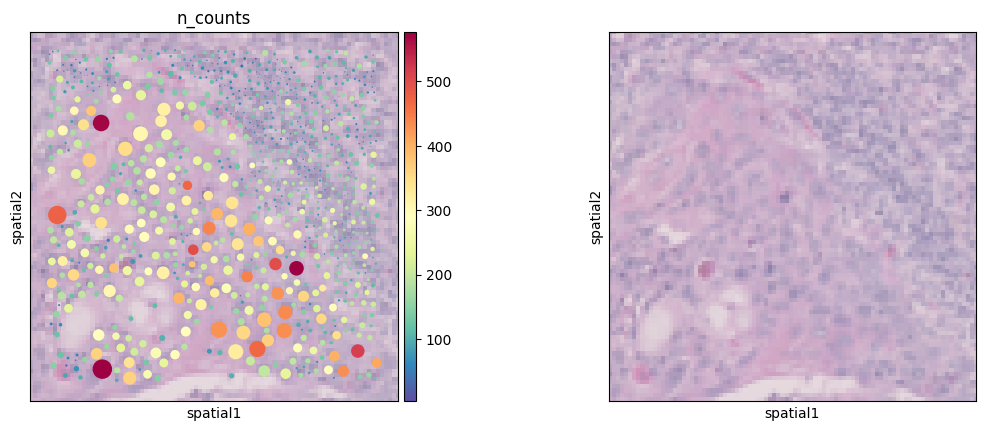

In [9]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

crop_axis_fraction = 0.05  # how much to crop around the center

# Get spatial coordinates
spatial_coords = adata_cells.obsm['spatial'].copy()

# Compute coordinate bounds and center
x_min, x_max = np.min(spatial_coords[:, 0]), np.max(spatial_coords[:, 0])
y_min, y_max = np.min(spatial_coords[:, 1]), np.max(spatial_coords[:, 1])
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds around center
x0 = center_x - (x_max - x_min) * crop_axis_fraction / 2
x1 = center_x + (x_max - x_min) * crop_axis_fraction / 2
y0 = center_y - (y_max - y_min) * crop_axis_fraction / 2
y1 = center_y + (y_max - y_min) * crop_axis_fraction / 2

# Find cells within crop
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped = adata_cells[within_crop, :].copy()

# Normalize n_bins to define spot sizes (you can adjust scaling)
sizes = adata_cropped.obs['n_bins']
sizes_normalized = 10 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cropped,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)


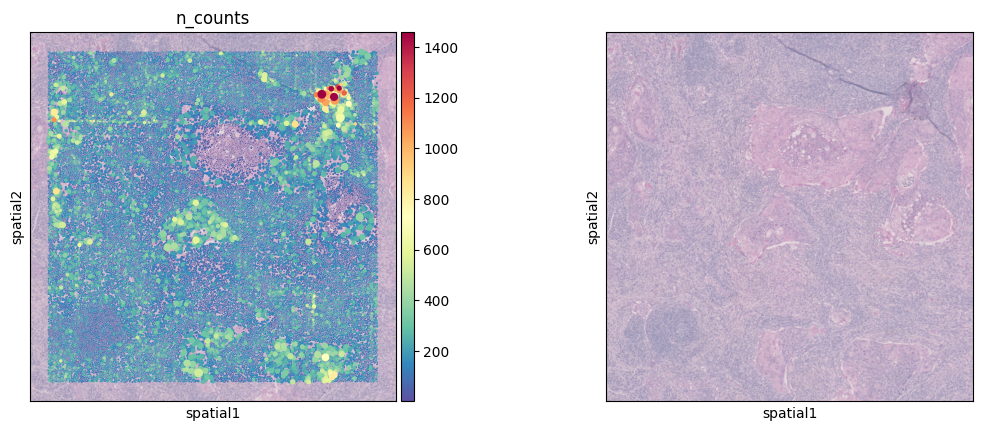

In [10]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

crop_axis_fraction = 0.33  # how much to crop around the center

# Get spatial coordinates
spatial_coords = adata_cells.obsm['spatial'].copy()

# Compute coordinate bounds and center
x_min, x_max = np.min(spatial_coords[:, 0]), np.max(spatial_coords[:, 0])
y_min, y_max = np.min(spatial_coords[:, 1]), np.max(spatial_coords[:, 1])
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2

# Define crop bounds around center
x0 = center_x - (x_max - x_min) * crop_axis_fraction / 2
x1 = center_x + (x_max - x_min) * crop_axis_fraction / 2
y0 = center_y - (y_max - y_min) * crop_axis_fraction / 2
y1 = center_y + (y_max - y_min) * crop_axis_fraction / 2

# Find cells within crop
within_crop = (
    (spatial_coords[:, 0] >= x0) & (spatial_coords[:, 0] <= x1) &
    (spatial_coords[:, 1] >= y0) & (spatial_coords[:, 1] <= y1)
)
adata_cropped = adata_cells[within_crop, :].copy()

# Normalize n_bins to define spot sizes (you can adjust scaling)
sizes = adata_cropped.obs['n_bins']
sizes_normalized = 30 * (sizes / sizes.max())  # scale to 0–20

# Plot
sc.pl.spatial(
    adata_cropped,
    color=['n_counts',None],
    size=sizes_normalized,
    cmap='Spectral_r',
    alpha_img=0.6,
    show=True
)


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


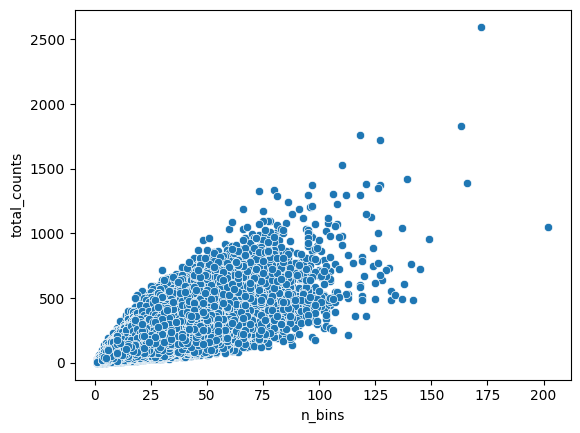

In [11]:
sc.pp.calculate_qc_metrics(adata_cells, inplace=True)
adata_cells.obs['n_bins'] = adata_cells.obs['n_bins'].astype(float)
sns.scatterplot(x=adata_cells.obs['n_bins'], y=adata_cells.obs['total_counts'])
plt.show()


In [12]:
adata_cells

AnnData object with n_obs × n_vars = 456287 × 18190
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

## QC Adata

In [13]:
import sys
sys.path.append("/opt/Banksy_py")
import banksy as banksy
import time; import random

from banksy.initialize_banksy import initialize_banksy
from banksy.run_banksy import run_banksy_multiparam
from banksy_utils.color_lists import spagcn_color
from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions
from banksy_utils.load_data import load_adata, display_adata
from banksy_utils.filter_utils import filter_cells
from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

import scipy.sparse
if not scipy.sparse.issparse(adata_cells.X):
    print('converting to sparse')
    adata_cells.X = scipy.sparse.csr_matrix(adata_cells.X)
    # adata.raw = adata.X
display_adata(adata_cells)


Displaying adata Object and their attributes
Adata attributes and dimensions:


AnnData object with n_obs × n_vars = 456287 × 18190
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell'
    obsm: 'spatial'

Matrix sparsity: 37308193 filled elements (0.00) out of 8299860530
max: 941.4475086932409, min: 0.12350211581579318

Displaying observations (adata.obs)


,n_counts,n_bins,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
1000,142.0,26.0,103,4.644391,174.844886,5.169602,67.719135,98.427177,100.0,100.0
10000,84.0,17.0,64,4.174387,83.756492,4.439782,88.258869,100.000000,100.0,100.0
100000,72.0,12.0,54,4.007333,86.923317,4.476465,95.559708,100.000000,100.0,100.0
100001,145.0,10.0,73,4.304065,141.297915,4.957923,86.820171,100.000000,100.0,100.0
100002,159.0,18.0,77,4.356709,210.117519,5.352415,85.761651,100.000000,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...
99995,67.0,10.0,38,3.663562,78.819344,4.379766,100.000000,100.000000,100.0,100.0
99996,85.0,15.0,48,3.891820,130.170040,4.876494,100.000000,100.000000,100.0,100.0
99997,74.0,14.0,46,3.850148,105.549801,4.668612,100.000000,100.000000,100.0,100.0
99998,108.0,6.0,51,3.951244,97.609074,4.591163,99.307561,100.000000,100.0,100.0


Displaying variables (adata.var)


,gene_ids,feature_types,genome,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
OR4F5,ENSG00000186092,Gene Expression,GRCh38,32,26,0.000069,0.000069,99.994302,31.481441,3.480669
SAMD11,ENSG00000187634,Gene Expression,GRCh38,449,369,0.000959,0.000958,99.919130,437.479172,6.083312
NOC2L,ENSG00000188976,Gene Expression,GRCh38,1233,1067,0.002785,0.002781,99.766156,1270.893110,7.148262
KLHL17,ENSG00000187961,Gene Expression,GRCh38,733,616,0.001596,0.001594,99.864997,728.105519,6.591818
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38,1097,909,0.002378,0.002375,99.800783,1084.989714,6.990247
...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,104556,62383,0.233678,0.210000,86.328122,106624.045820,11.577074
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,96628,60098,0.215204,0.194912,86.828904,98194.591009,11.494717
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,18114,14312,0.039851,0.039077,96.863378,18183.342386,9.808316
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,43644,33412,0.095560,0.091266,92.677416,43602.973833,10.682904


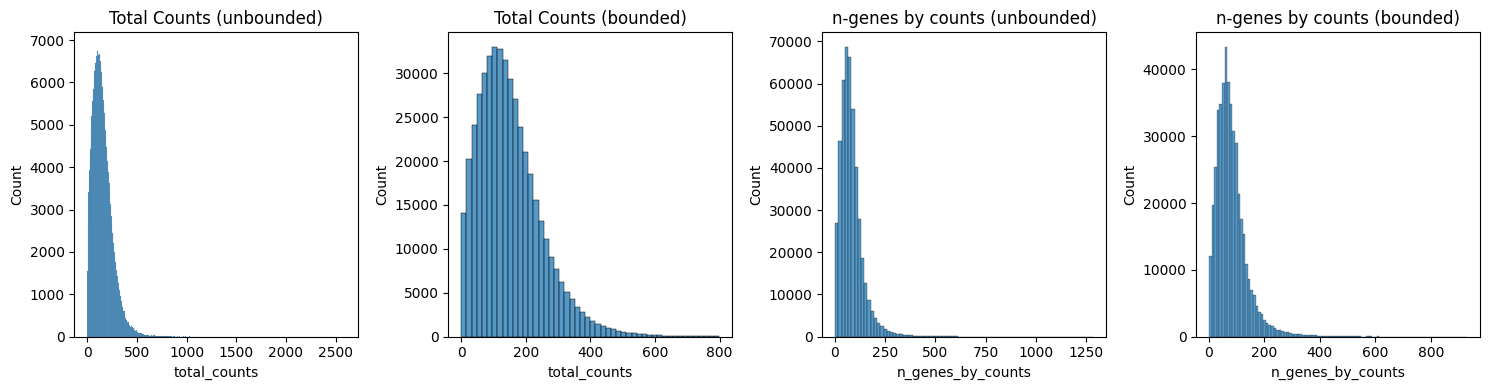

In [14]:
# QC
adata_cells.var_names_make_unique()
adata_cells.var["mt"] = adata_cells.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata_cells, 
                           qc_vars=["mt"], 
                           log1p=True, 
                           inplace=True)

# bin options for fomratting histograms
# Here, we set 'auto' for 1st figure, 80 bins for 2nd figure. and so on
hist_bin_options = ['auto', 50, 80, 100]

plot_qc_hist(adata_cells, 
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
         bin_options = hist_bin_options)

Cells before filtering: 456287

Cells after count filter: 451965

cells after MT filter: 451241



/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Genes after minimum cells per gene filter: 13139



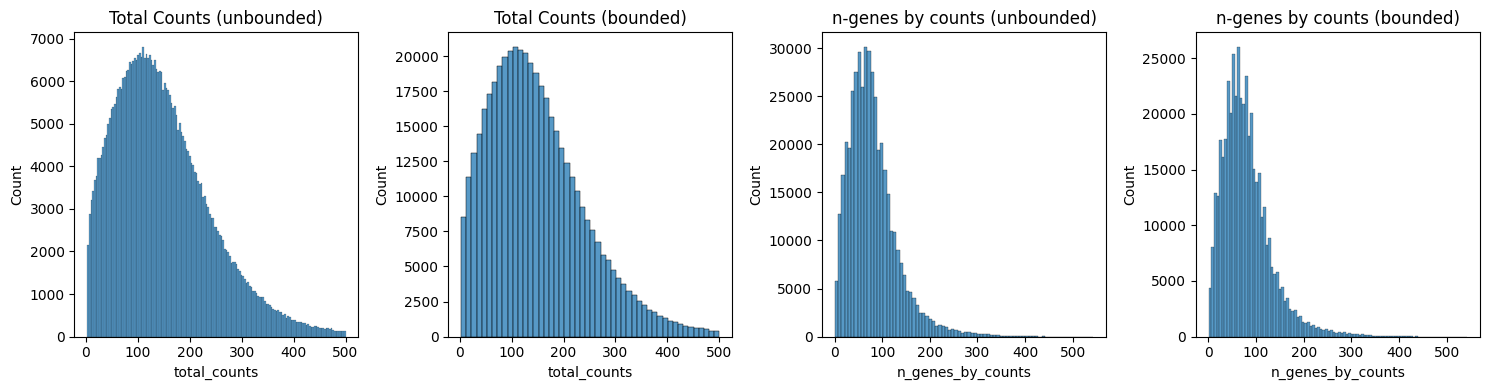

In [15]:
# initial filter of cells by their cell counts, MT count and gene counts
adata_filtred = adata_cells.copy()

adata_filtred = filter_cells(adata_filtred, 
             min_count=3, 
             max_count=500, 
             MT_filter=20, 
             gene_filter=100)

plot_qc_hist(adata_filtred,
         total_counts_cutoff = 800, # for visualization
         n_genes_high_cutoff = 1000, # for visualization
         n_genes_low_cutoff = 0, # for visualization
        bin_options = hist_bin_options)


## Normalize and scale

In [16]:
#Identify highly variable genes — modify filter_hvg to skip log1p inside
adata_normalized = adata_filtred.copy()
adata_normalized = normalize_total(adata_normalized)
sc.pp.log1p(adata_normalized)


--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 285.0330229556366, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 134.7132480717653, Min: 0.0



In [17]:

sc.pp.highly_variable_genes(adata_normalized, n_top_genes=5000, flavor='seurat')

nsclc_marker_genes = sorted(list(set([
    # T cells
    'CD3D', 'CD3E', 'CD3G', 'CD2', 'CD7', 'TRAC', 'JUNB', 'S100A4', 'CD52', 'PFN1P1',
    'CD81', 'EEF1B2P3', 'CXCR4', 'CREM', 'IL32', 'TGIF1',

    # CD4+ T cells
    'CD4', 'IL7R', 'CCR7', 'SELL', 'FOXP3', 'CTLA4', 'TIGIT',

    # CD8+ T cells
    'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'LAG3', 'PDCD1',

    # Regulatory T cells
    'IL2RA', 'IKZF2',

    # B cells
    'CD19', 'MS4A1', 'CD79A', 'CD79B', 'IGHD', 'IGHM', 'CD22', 'CD24',
    'CD74', 'HMGA1', 'CD52', 'PTPRC', 'HLA-DRA', 'CXCR4', 'SPCS3', 'LTB', 'IGKC',

    # Plasma cells
    'MZB1', 'JCHAIN', 'SDC1', 'XBP1',

    # NK cells
    'NCAM1', 'KLRB1', 'KLRD1', 'NKG7', 'GNLY', 'PRF1', 'FGFBP2',
    'IL32', 'FHL2', 'IL2RG', 'CD69', 'HOPX',

    # Dendritic cells
    'ITGAX', 'CD1C', 'CLEC9A', 'CD83', 'LAMP3', 'CCR7', 'HLA-DRA', 'BATF3',

    # Monocytes / Macrophages
    'CD14', 'CD68', 'LYZ', 'FCN1', 'S100A8', 'S100A9', 'ITGAM', 'MRC1', 'CD163',
    'NOS2', 'IL1B', 'TNF', 'ARG1', 'CD206', 'IL10',

    # Neutrophils
    'FCGR3B', 'CSF3R', 'ELANE', 'MPO', 'CEACAM8',

    # Endothelial
    'PECAM1', 'VWF', 'CDH5', 'KDR', 'CLDN5', 'ESAM', 'ENG', 'CD34', 'PROM1', 'PDPN',
    'TEK', 'FLT1', 'VCAM1', 'PTPRC', 'MCAM', 'ICAM1', 'FLT4',

    # Fibroblasts / CAFs
    'PDGFRA', 'PDGFRB', 'COL1A1', 'COL1A2', 'COL3A1', 'COL5A2', 'ACTA2', 'TAGLN', 'FAP', 'POSTN',
    'TCF21', 'FN',

    # Pericytes / Smooth muscle
    'RGS5', 'MYL9', 'MYLK', 'FHL2', 'ITGA1', 'EHD2', 'OGN', 'SNCG', 'FABP4',

    # Epithelial / Alveolar / Cancer cells
    'EPCAM', 'KRT8', 'KRT18', 'KRT19', 'SFTPC', 'SFTPB', 'AGER', 'PDPN', 'KRT7', 'KRT5', 'KRT14',
    'TP63', 'NGFR', 'MUC1', 'MUC16', 'BIRC5', 'MYC', 'SOX2', 'CCND1', 'CDKN2A', 'PD-L1',
    'EGFR', 'KRAS', 'TP53', 'TTF-1', 'NKX2-1', 'CEACAM5', 'CDH1', 'CLDN1',

    # Club/secretory cells
    'SCGB1A1', 'SCGB3A2', 'MUC5B',

    # Ciliated cells
    'FOXJ1', 'TPPP3', 'PIFO', 'DNAH5',

    # Goblet cells
    'MANF', 'KRT7', 'AQP3', 'AGR2', 'BACE2', 'TFF3', 'PHGR1', 'MUC4', 'MUC13', 'GUCA2A',

    # Enterocytes
    'CD55', 'ELF3', 'PLIN2', 'GSTM3', 'KLF5', 'CBR1', 'APOA1', 'CA1', 'PDHA1', 'EHF',

    # Enteroendocrine
    'NUCB2', 'FABP5', 'CPE', 'ALCAM', 'GCG', 'SST', 'CHGB', 'IAPP', 'CHGA', 'ENPP2',

    # Crypt cells / stem-like
    'HOPX', 'SLC12A2', 'MSI1', 'SMOC2', 'OLFM4', 'ASCL2', 'PROM1', 'BMI1', 'EPHB2', 'LRIG1',

    # Cancer stem cells
    'CD44', 'PROM1', 'ALDH1A1', 'ITGA6',

    # Immune checkpoints / tumor markers
    'PDCD1', 'CTLA4', 'HAVCR2', 'TIGIT', 'LAG3', 'CD274', 'PDCD1LG2',
    'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DQA1', 'HLA-DPB1'
])))

hvg_genes = adata_normalized.var_names[adata_normalized.var['highly_variable']].tolist()
combined_genes = list(set(hvg_genes + nsclc_marker_genes))
genes_to_keep = [g for g in combined_genes if g in adata_normalized.var_names]
adata_normalized = adata_normalized[:, genes_to_keep]
adata_normalized

View of AnnData object with n_obs × n_vars = 451241 × 5088
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell', 'log1p', 'hvg'
    obsm: 'spatial'

## Clustering

/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:325: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


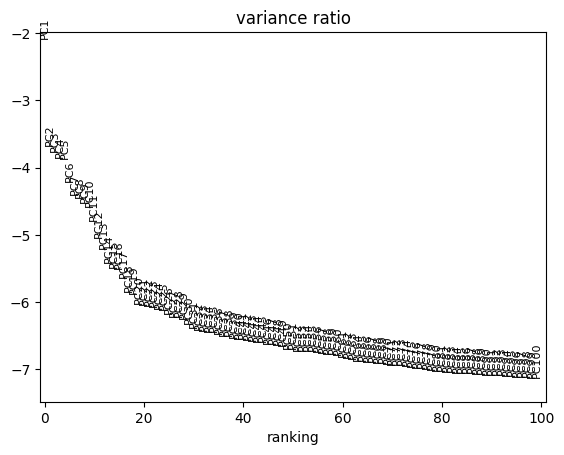

In [18]:
sc.tl.pca(adata_normalized, svd_solver='arpack',n_comps=100)
# “elbow” — the point where additional PCs contribute little variance — and use that number in n_pcs.
sc.pl.pca_variance_ratio(adata_normalized, log=True, n_pcs=100)

Clustering with resolution = 0.2


/tmp/ipykernel_2347802/1838375495.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Clustering done, ploting...


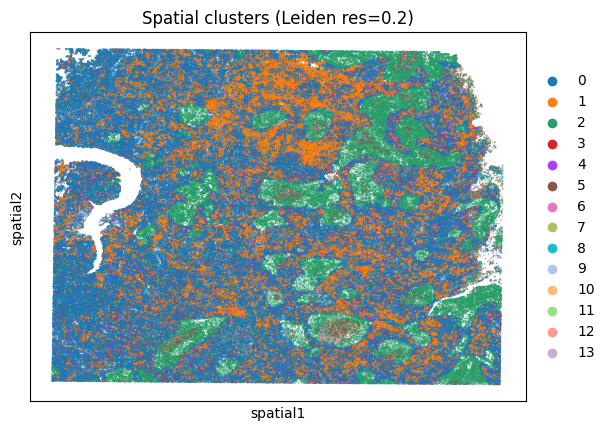

In [19]:
import scanpy as sc

# Parameters
NNei = 30
res = 0.2
nPCs = 30

# 1. Compute neighborhood graph
sc.pp.neighbors(adata_normalized, n_neighbors=NNei, n_pcs=nPCs)

print(f'Clustering with resolution = {res}')
# 2. Run Leiden clustering
leiden_key = f'nn_{NNei} leiden_{res}'
sc.tl.leiden(
    adata_normalized,
    resolution=res,
    key_added=leiden_key,
)
print(f'Clustering done, ploting...')

sc.pl.embedding(
    adata_normalized,
    basis="spatial",
    color=f'nn_{NNei} leiden_{res}',
    size=5,
    alpha=0.6,
    title=f"Spatial clusters (Leiden res={res})",
    show=False
)
plt.gca().invert_yaxis()
plt.show()



Generating UMAP for resolution = 0.2
UMAP done, ploting...


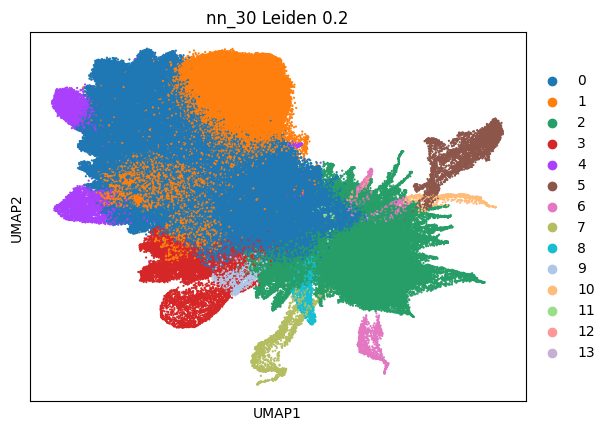

In [20]:
print(f'Generating UMAP for resolution = {res}')

# 3. Compute UMAP embedding
sc.tl.umap(adata_normalized)

print(f'UMAP done, ploting...')

# 5. Plot UMAP colored by clustering result
sc.pl.umap(
    adata_normalized,
    color=leiden_key,
    title=f'nn_{NNei} Leiden {res}',
    size=10  # adjust based on dataset
)


## Annotation

# DE clusters

In [21]:
adata_normalized.obs.sample()

,n_counts,n_bins,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,nn_30 leiden_0.2
354772,120.400654,15.0,80,4.394449,120.400654,4.799096,77.486657,100.0,100.0,100.0,1.083333,0.733969,0.899774,1


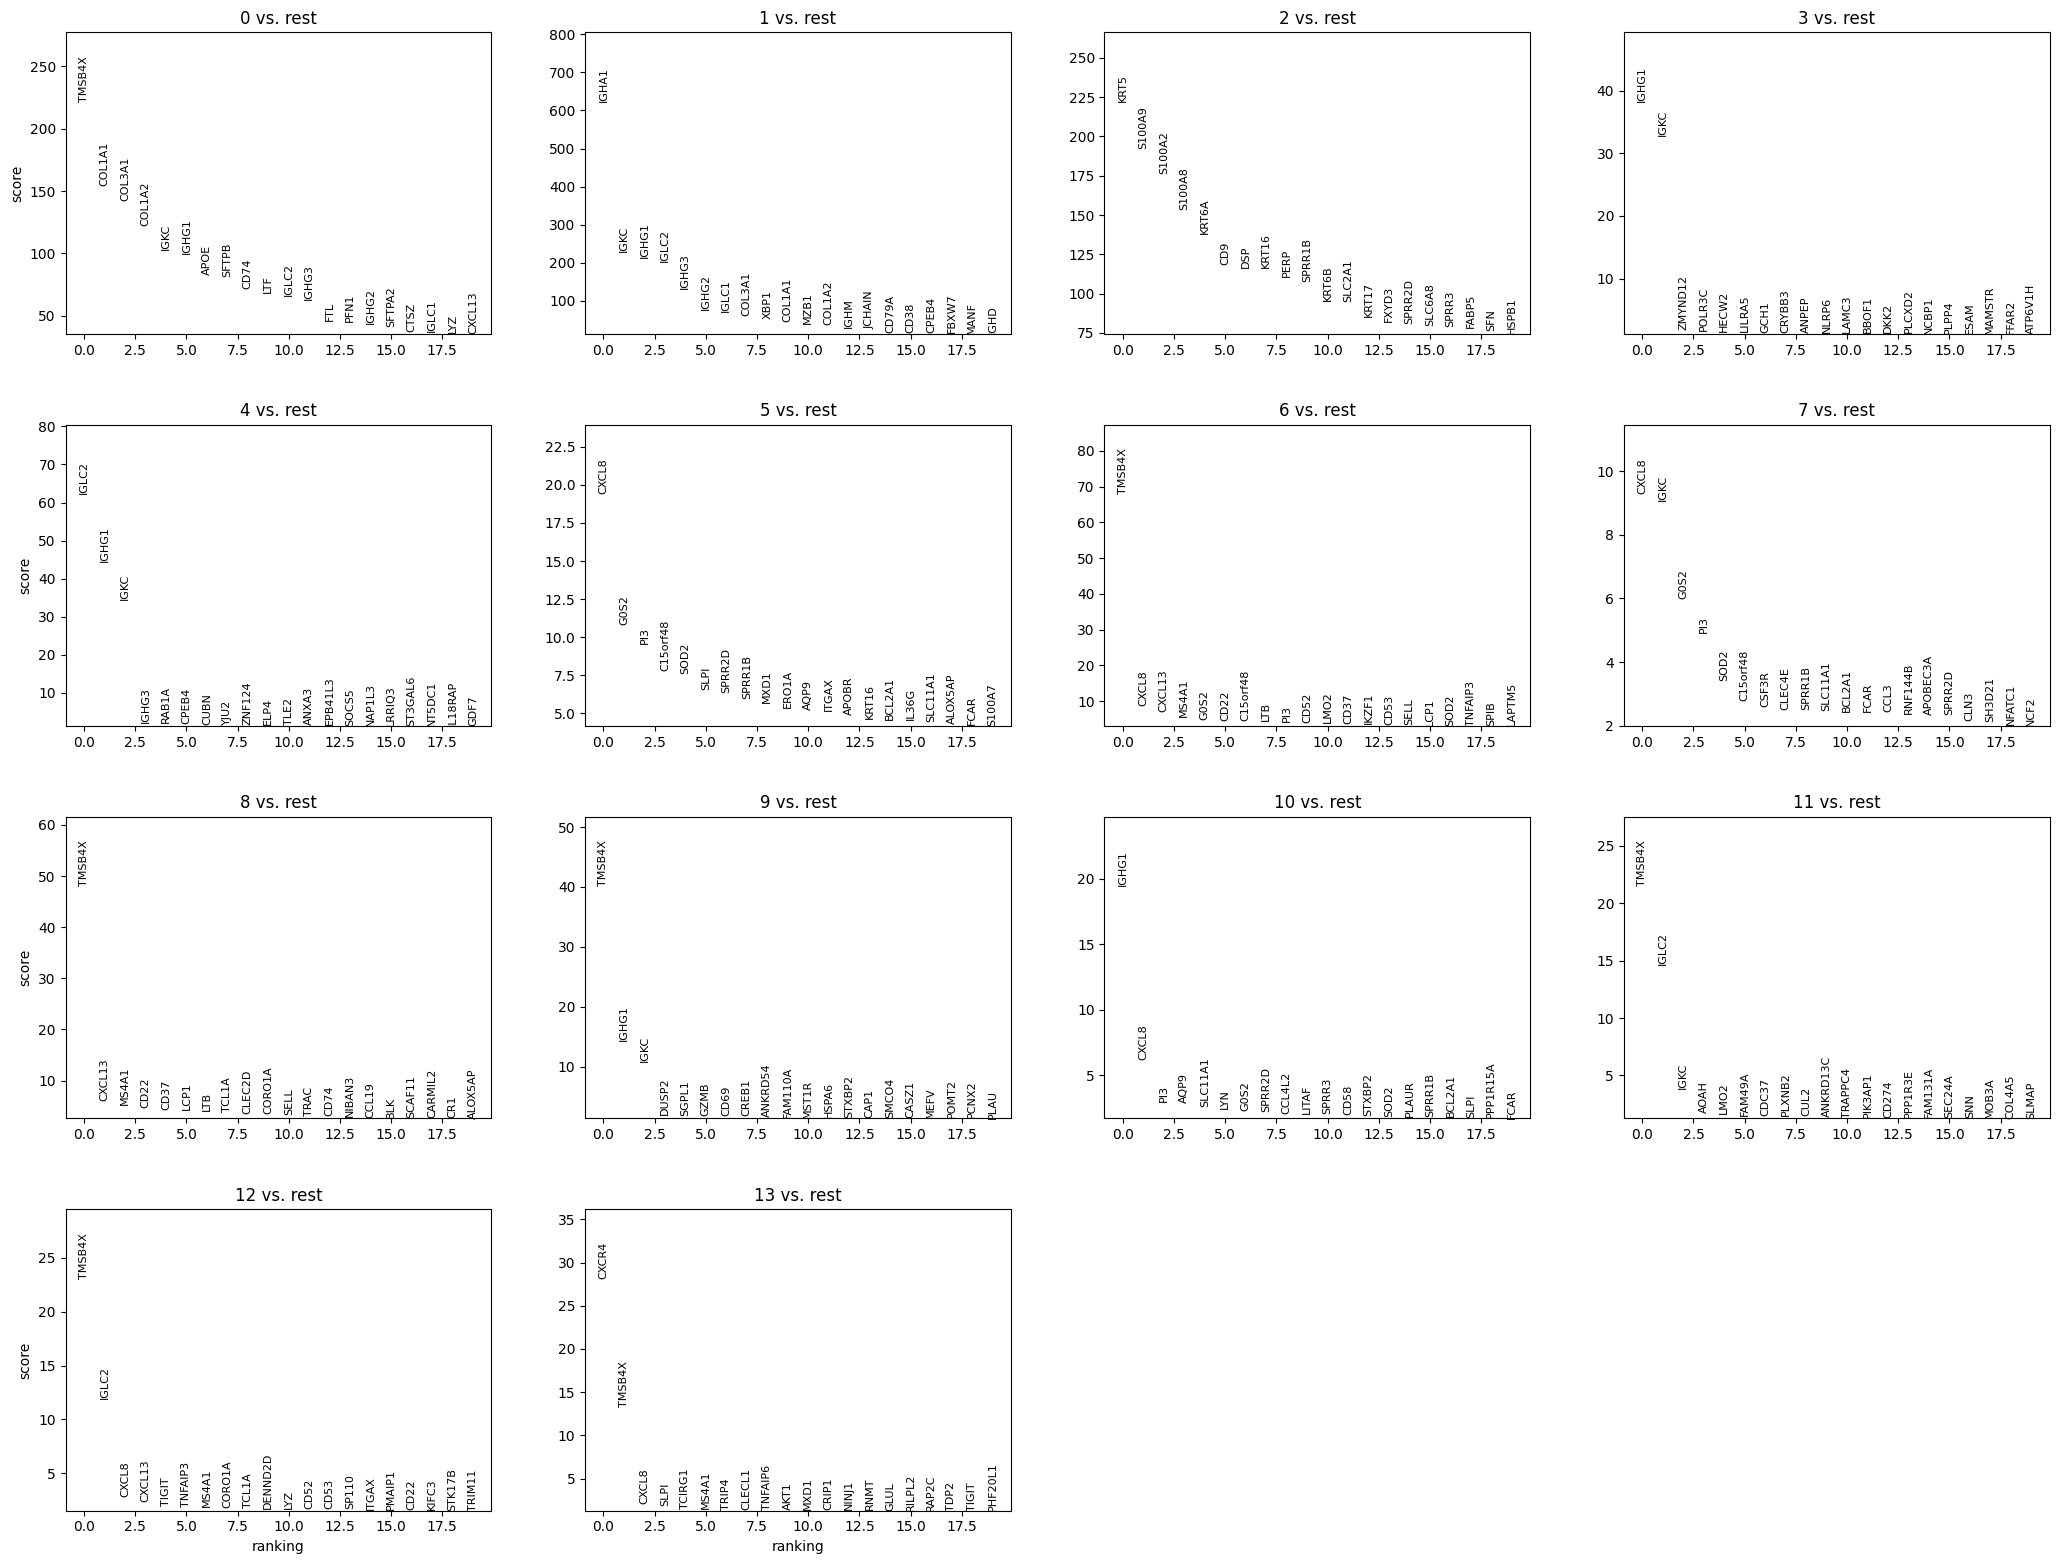

In [22]:
import scanpy as sc

# Make sure your AnnData object has cluster labels
cluster_key = "nn_30 leiden_0.2"  # change to your actual key, e.g., "nn_30 leiden_0.5"
if cluster_key not in adata_normalized.obs:
    raise ValueError(f"{cluster_key} not found in adata.obs")

# Perform differential expression
sc.tl.rank_genes_groups(
    adata_normalized,
    groupby=cluster_key,
    method='t-test_overestim_var',  # or 'wilcoxon', 'logreg'
    use_raw=False,
    n_genes=100,
)

# Plot top DE genes
sc.pl.rank_genes_groups(adata_normalized, n_genes=20, sharey=False)


In [23]:
adata_normalized.write(os.path.join('./', f"{sample_id}_clustered_leiden_allcells.h5ad"))


# Banksy

In [24]:
adata_normalized, adata_allgenes = filter_hvg(
    adata_normalized,
    n_top_genes=1000,
    flavor="seurat"
)

--- Normalized and log-transformed data -----
Displaying max and min of Dataset
Max: 1.7767379066583175, Min: 0.0

Displaying dataset after filtering by HVG
View of AnnData object with n_obs × n_vars = 451241 × 1000
    obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'nn_30 leiden_0.2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'sample_id', 'sample_metadata', 'bin2cell', 'log1p', 'hvg', 'pca', 'neighbors', 'nn_30 leiden_0.2', 'nn_30 leiden_0.2_colors', 'umap', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'X_umap'
   

In [25]:
from banksy.main import median_dist_to_nearest_neighbour

# set params
# ==========
plot_graph_weights = True
k_geom = 15 # only for fixed type
max_m = 1 # azumithal transform up to kth order
nbr_weight_decay = "scaled_gaussian" # can also be "reciprocal", "uniform" or "ranked"
coord_keys=('spatial_0', 'spatial_1','spatial')

# # Find median distance to closest neighbours, the median distance will be `sigma`
# nbrs = median_dist_to_nearest_neighbour(adata, key = coord_keys[2])


Median distance to closest cell = 30.092542718027442

---- Ran median_dist_to_nearest_neighbour in 1.71 s ----

---- Ran generate_spatial_distance_graph in 3.84 s ----

---- Ran row_normalize in 1.05 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 10.66 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 62.68518267410911, mode = 61.5804509204478

---- Ran plot_edge_histogram in 0.16 s ----


Edge weights (weights between cells): median = 0.05892813171432062, mode = 0.03234402613345831

---- Ran plot_edge_histogram in 0.13 s ----

---- Ran generate_spatial_distance_graph in 5.89 s ----

---- Ran theta_from_spatial_graph in 3.84 s ----

---- Ran row_normalize in 1.06 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 16.90 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 87.82403665219314, mode = 87.54598917369881

---- Ran plot_edge_histogram in 0.20 s ----



/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7132: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16
/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)



Edge weights (weights between cells): median = (-1.1573741550937316e-05+0.014475885556410103j), mode = 0.010681422937497076

---- Ran plot_edge_histogram in 0.77 s ----

----- Plotting Weights Graph -----
Maximum weight: 0.21555932579728404

---- Ran plot_graph_weights in 64.03 s ----

Maximum weight: (0.08629455993527545-0.008657792589651716j)

---- Ran plot_graph_weights in 124.64 s ----

----- Plotting theta Graph -----


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/matplotlib/collections.py:430: ComplexWarning: Casting complex values to real discards the imaginary part
  renderer.draw_path_collection(


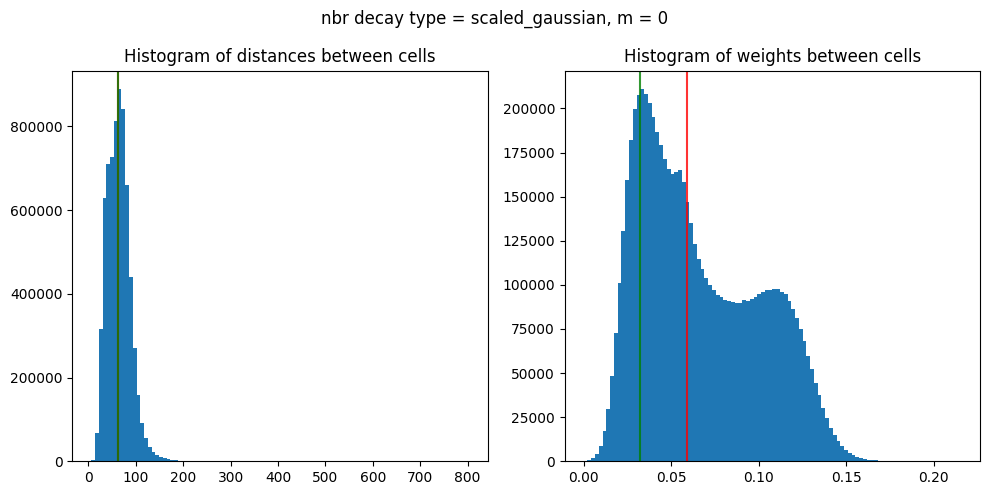

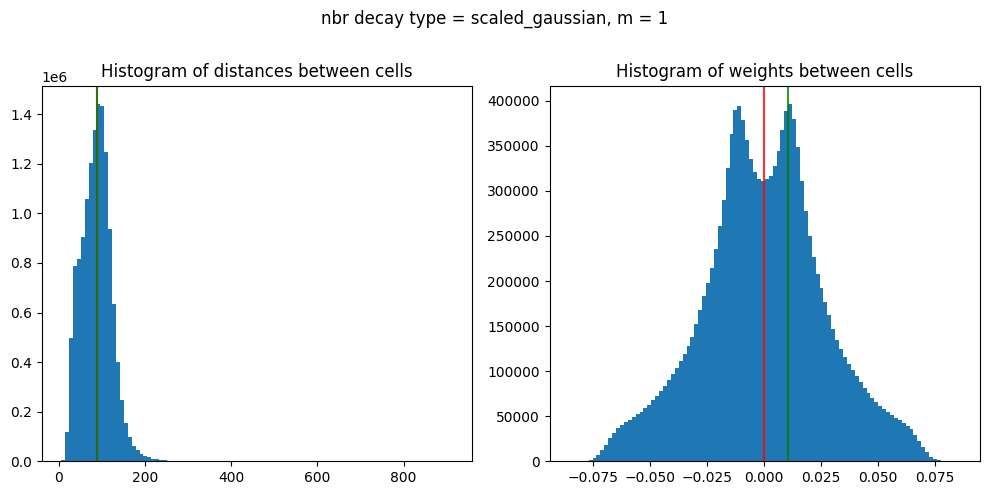

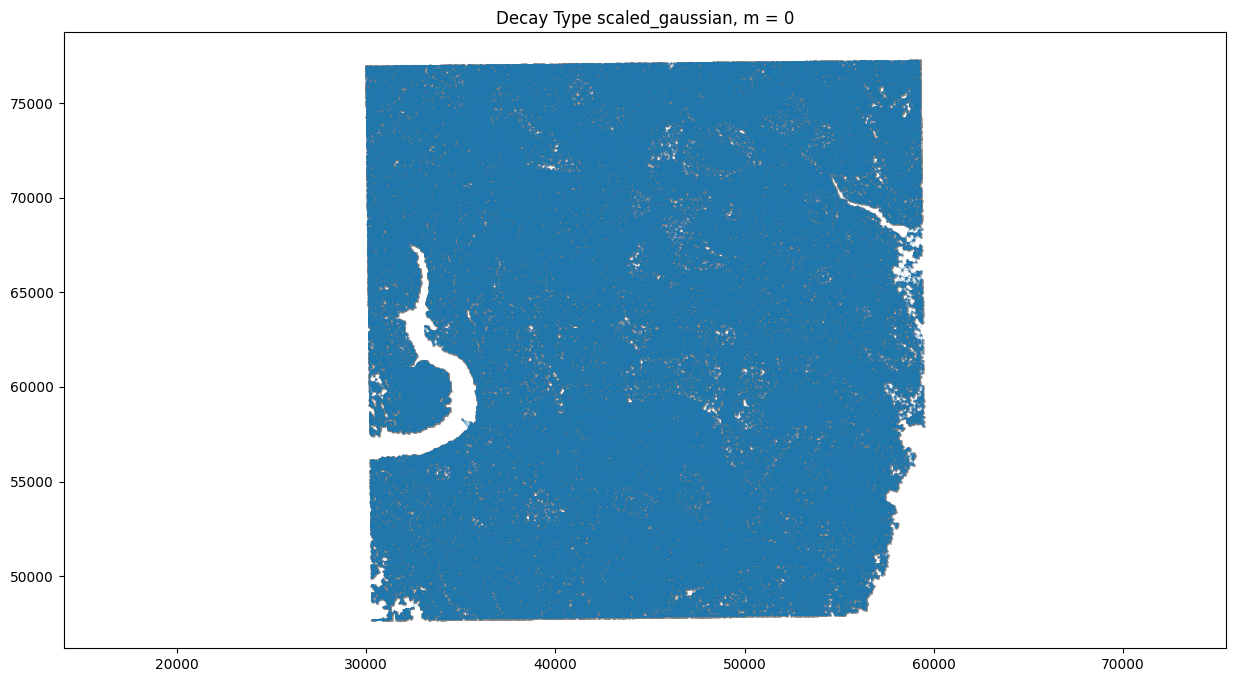

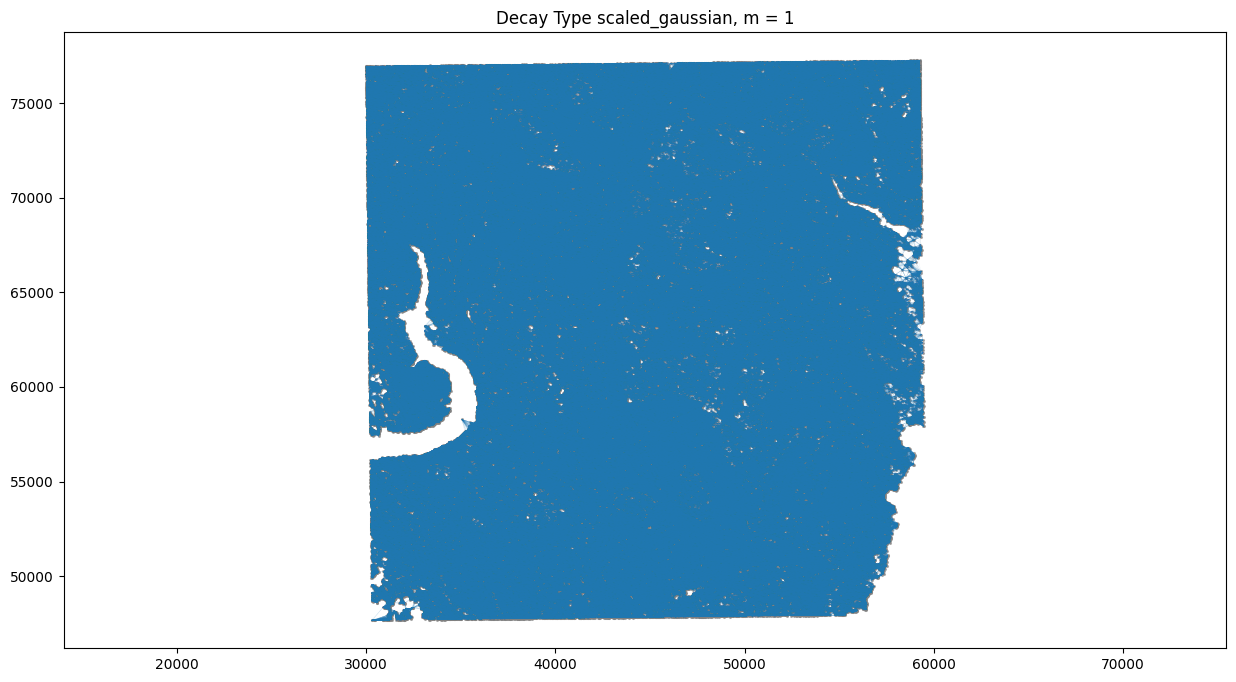

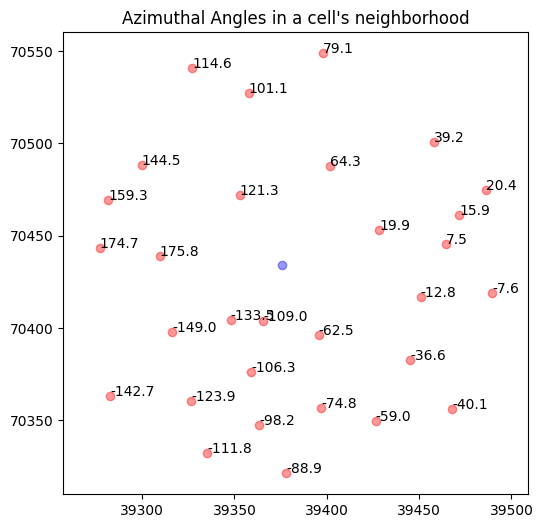

In [26]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata_normalized,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

In [27]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
resolutions = [1] # clustering resolution for UMAP
pca_dims = [50] # Dimensionality in which PCA reduces to
lambda_list = [0.2] # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata_normalized, banksy_dict, lambda_list, max_m)

Runtime Jul-12-2025-16-37

1000 genes to be analysed:
Gene List:
Index(['AC005726.1', 'LARGE1', 'HCK', 'A2ML1', 'NDRG1', 'RENBP', 'SLC4A8',
       'SPINT1', 'DENND3', 'GLOD4',
       ...
       'ELF4', 'SPP1', 'TECTA', 'CLCF1', 'IGLC1', 'TRAF1', 'TMEM71', 'KCNJ11',
       'DUOXA2', 'SLC25A13'],
      dtype='object', length=1000)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6768615 stored elements and shape (451241, 451241)>, 1: <Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 13537230 stored elements and shape (451241, 451241)>}}

Nbr matrix | Mean: 0.01 | Std: 0.13
Size of Nbr | Shape: (451241, 1000)
Top 3 entries of Nbr Mat:

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

AGF matrix | Mean: 0.0 | Std: 0.02
Size of AGF mat (m = 1) | Shape: (451241, 1000)
Top entries of AGF:
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.    

In [28]:
# from banksy.main import concatenate_all

# banksy_dict["nonspatial"] = {
#     # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
#     0.0: {"adata": concatenate_all([adata_normalized.X], 0, adata=adata_normalized), }
# }

# print(banksy_dict['nonspatial'][0.0]['adata'])

In [29]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True,
         plt_remaining_var = False,
         )

Current decay types: ['scaled_gaussian']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 50
Original shape of matrix: (451241, 3000)
Reduced shape of matrix: (451241, 50)
------------------------------------------------------------
min_value = -43.97765221679008, mean = -4.671085059049571e-15, max = 63.76871003344874

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_50_umap"]


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP embedding
------------------------------------------------------------
shape: (451241, 2)


AxisArrays with keys: reduced_pc_50, reduced_pc_50_umap


In [30]:
banksy_dict

{'scaled_gaussian': {'weights': {0: <Compressed Sparse Row sparse matrix of dtype 'float64'
   	with 6768615 stored elements and shape (451241, 451241)>,
   1: <Compressed Sparse Row sparse matrix of dtype 'complex128'
   	with 13537230 stored elements and shape (451241, 451241)>},
  'norm_counts_concatenated': <COOrdinate sparse matrix of dtype 'float64'
  	with 60425520 stored elements and shape (451241, 3000)>,
  0.2: {'adata': AnnData object with n_obs × n_vars = 451241 × 3000
       obs: 'n_counts', 'n_bins', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'nn_30 leiden_0.2'
       var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'hi

In [ ]:
from banksy.cluster_methods import run_Leiden_partition
seed = 123

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = seed,
    match_labels = True,
)

Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.2
reduced_pc_50 

reduced_pc_50_umap 

PCA dims to analyse: [50]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.2, PCA dimensions = 50)



In [ ]:
from banksy.plot_banksy import plot_results

c_map =  'nipy_spectral' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]
file_path = './spatialclustering/{sample_id}/'

coord_keys=('spatial_0', 'spatial_1','spatial')

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = coord_keys,
    max_num_labels  =  max_num_labels, 
    save_path = os.path.join(file_path, 'banksy_tmp_png'),
    save_fig = True, # save the spatial map of all clusters
    save_seperate_fig = True, # save the figure of all clusters plotted seperately
)